# Structured hierarchical models

The goal of this project is to model essential genes for multiple conditions given that we have prior knowledge about functional relations of these genes. The model we want to use is:

\begin{align}
\mathbf{z} & \sim \text{MRF} \\
\tau^2 & \sim P(\cdot) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau^2) \\
\beta_{vg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{vg} & \sim \text{Gamma}(1, 1) \\
\sigma_2 & \sim \text{Half-Cauchy}(0, 1) \\
x_{svg} \mid \beta_{vg} &  \sim \text{Pois}\left(l_{vg} \cdot \exp \left( \beta_{vg} \right), \sigma^2\right) \\
\end{align}


We start with some simple models, see them in the other notebooks.

In [5]:
import warnings
warnings.filterwarnings("ignore")
import os

In [2]:
import pandas as pd
import pymc3 as pm
import numpy as np
import scipy as sp
import theano.tensor as tt

In [3]:
from sklearn import preprocessing
from pymc3 import  model_to_graphviz

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az

sns.set_style(
    "white", 
    {'xtick.bottom': True,
     'ytick.left': True,
     'axes.spines.top': False, 
     'axes.spines.right': False})

Since the MRF is particularly hard to estimate, we make use of a simpler representation first.

\begin{align}
\boldsymbol \pi & \sim \text{Dirichlet}(1, 1) \\
z_g & \sim \text{Categorical}(\boldsymbol \pi) \\
\tau_g^2 & \sim \text{Gamma}(1, 1) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau_g^2) \\
\tau_b^2 & \sim \text{Gamma}(1, 1) \\
\beta_{cg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau_b^2) \\
l_{cgs} & \sim \text{Lognormal}(1, 1) \\
x_{cgs} \mid \beta_{vg} &  \sim \text{Pois}\left(l_{vgs} \cdot \exp \left( \beta_{cg} \right) \right) \\
\end{align}

## Data

In [7]:
file_path = os.path.join('../', 'data_raw', 'read_counts-normalized.tsv')
file_path

'../data_raw/read_counts-normalized.tsv'

In [75]:
sirna_data = pd.read_csv(file_path, sep="\t")

In [76]:
sirna_data = sirna_data.query("Gene != 'Control'")

In [77]:
sirna_data = sirna_data[["sgRNA", "Gene", "LSLCas9_134", "LSLCas9_136"]]

In [78]:
sirna_data = sirna_data.rename(index=str, columns={"LSLCas9_134": "r1", "LSLCas9_136": "r2"})

In [79]:
sirna_data = sirna_data.melt(id_vars=['sgRNA', 'Gene'], value_vars=['r1', 'r2'],
                             var_name='replicate', value_name='counts')

In [80]:
sirna_data[:5]

,sgRNA,Gene,replicate,counts
0,ACSM3_sg001,ACSM3,r1,8987.015957
1,ACSM3_sg002,ACSM3,r1,15742.897879
2,ACSM3_sg003,ACSM3,r1,17348.226026
3,ACSM3_sg004,ACSM3,r1,9330.654939
4,ACSM3_sg005,ACSM3,r1,8995.077869


In [82]:
sirna_data = sirna_data[["Gene", "sgRNA", "replicate", "counts"]].sort_values(['Gene', 'sgRNA', 'replicate'])

In [85]:
sirna_data[:5]

,Gene,sgRNA,replicate,counts
0,ACSM3,ACSM3_sg001,r1,8987.015957
900,ACSM3,ACSM3_sg001,r2,9300.411518
1,ACSM3,ACSM3_sg002,r1,15742.897879
901,ACSM3,ACSM3_sg002,r2,15869.905865
2,ACSM3,ACSM3_sg003,r1,17348.226026


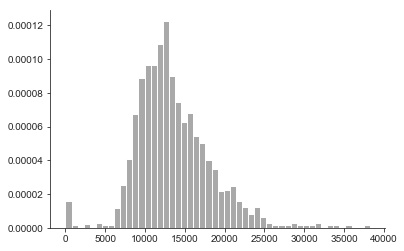

In [107]:
plt.hist(sirna_data[["counts"]].values, color="darkgrey", bins=50, density=True);
plt.show()

Since it is always _both_ replicates that have a low read count, it is safe to assume that these are no batch effects.

## Inference

In [ ]:
with pm.Model() as model:
    p = pm.Dirichlet('p', a=np.array([1., 1.]), shape=2)
    p_min_pot = pm.Potential('p_pot', tt.switch(tt.min(p) < .05, -np.inf, 0))
    category = pm.Categorical('category', p=p, shape=4)
    
    tau_g = pm.HalfCauchy('tau_g', 1., shape=1)
    mean_g = pm.Normal('mu_g', mu=np.array([0, 1]), sd=.5, shape=2)
    mean_order_pot = pm.Potential('mop', tt.switch(mean_g[1] - mean_g[0] < 0, -np.inf, 0))    
    gamma = pm.Normal('gamma', mean_g[category], tau_g, shape=4)
    
    tau_b = pm.HalfCauchy('tau_b', 1., shape=1)
    beta = pm.Normal('beta', gamma[np.repeat([0, 1, 2, 3], 2)], tau_b, shape=8)
    l = pm.Lognormal('l', 0, .25, shape = 4 * 2 * 2)
    
    x = pm.Poisson(
        'x', 
        mu = np.exp(beta[beta_idx]) * l[l_idx] ,
        observed=counts)